# Process Bursts

This notebook computes the burst drift for all bursts using the method show in `BurstDrift.ipynb`

In [1]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts = pd.read_csv('bursts.csv')

# Gaussian 2d Fit Stuff
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)

    rotation = np.deg2rad(rotation)
    center_x_old = center_x
    center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y = center_x_old * np.sin(rotation) + center_y * np.cos(rotation)

    def rotgauss(x,y):
        xp = x * np.cos(rotation) - y * np.sin(rotation)
        yp = x * np.sin(rotation) + y * np.cos(rotation)
        g = height*np.exp( -(((center_x-xp)/width_x)**2  +((center_y-yp)/width_y)**2)/2.  )
        return g
    return rotgauss

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0

def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = point
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
    return g.ravel()

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = scipy.optimize.leastsq(errorfunction, params)
    return p, success

def fitgaussiannlsq(data):
    # use curve-fit (non-linear leastsq)
    x = range(0, 1023); y = range(0, 1023)
    x, y = np.meshgrid(x, y)
    params = moments(data)#+ (0.,)
    popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), corr.ravel(), p0=params)
    return popt, pcov

In [2]:
folder = 'data'
outfolder = 'figures'
for burst, filename, edge in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge']), total=len(bursts['filename']) ):
    print('processing {}'.format(filename))
    if 'gajjar' in filename:
        continue
    if burst is not 10: continue

    junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    Q, U, V = None, None, None
    n = len(junk)
    print("Data loaded")
    
    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    tmin = 500 
    tmax = 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :

            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


        for j in range(tmax+1,binmax+1) :

            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

    #### 2. find autocorrelation 
    burstwindow = intensity[:,edge:edge+frequencymax]
    print("finding auto-correlation...")
    corr = signal.correlate2d(burstwindow, burstwindow, mode='full')

  0%|          | 0/18 [00:00<?, ?it/s]

processing 01_puppi_57747_C0531+33_0558_5.dm559.72.calibP.RM.DD.ASCII
processing 02_puppi_57747_C0531+33_0558_1183.dm559.72.calibP.RM.DD.ASCII
processing 03_puppi_57747_C0531+33_0558_1202.dm559.72.calibP.RM.DD.ASCII
processing 04_puppi_57747_C0531+33_0558_25437.dm559.72.calibP.RM.DD.ASCII
processing 05_puppi_57747_C0531+33_0558_3683.dm559.72.calibP.RM.DD.ASCII
processing 06_puppi_57747_C0531+33_0558_3687.dm559.72.calibP.RM.DD.ASCII
processing 07_puppi_57747_C0531+33_0558_3688.dm559.72.calibP.RM.DD.ASCII
processing 08_puppi_57747_C0531+33_0558_3689.dm559.72.calibP.RM.DD.ASCII
processing 09_puppi_57747_C0531+33_0558_3690.dm559.72.calibP.RM.DD.ASCII
processing 10_puppi_57747_C0531+33_0558_12568.dm559.72.calibP.RM.DD.ASCII
Data loaded
finding auto-correlation...


 56%|█████▌    | 10/18 [10:57<08:45, 65.75s/it]

processing 11_puppi_57748_C0531+33_0594_2.dm559.72.calibP.RM.DD.ASCII
processing 12_puppi_57748_C0531+33_0594_48.dm559.72.calibP.RM.DD.ASCII
processing 13_puppi_57748_C0531+33_0594_49.dm559.72.calibP.RM.DD.ASCII
processing 14_puppi_57748_C0531+33_0594_50.dm559.72.calibP.RM.DD.ASCII
processing 15_puppi_57748_C0531+33_0594_1269.dm559.72.calibP.RM.DD.ASCII
processing 16_puppi_57772_C0531+33_0007_2695.dm559.72.calibP.RM.DD.ASCII
processing gajjar/11A_16sec.calib.4p.RM.scr.ASCII
processing gajjar/11D_323sec.calib.4p.RM.scr.ASCII


100%|██████████| 18/18 [10:57<00:00, 36.53s/it]


In [4]:
    
    #### 3. Fit Gaussian to autocorrelation
    popt, pcov = fitgaussiannlsq(corr)
    perr = np.sqrt(np.diag(pcov))
    x = range(0, 1023); y = range(0, 1023)
    x, y = np.meshgrid(x, y)
    fitmap2 = twoD_Gaussian((x, y), *popt).reshape(1023, 1023)
    print('solution nlsq:', popt)
    print('parameter 1sigma:', perr)
    

solution nlsq: [   5.91208449  511.00000037  511.00000007 -130.60561575  -47.07411294
   -1.39244814]
parameter 1sigma: [0.07228006 0.63302199 1.57330265 1.59534473 0.57523675 0.00716349]


solver angle: -1.3924481394557087 pos angle: -1.3924481394557087
drift: -846.4712165059323
drift error: 34.73096697530797
saved figures/burst_10_figure.png


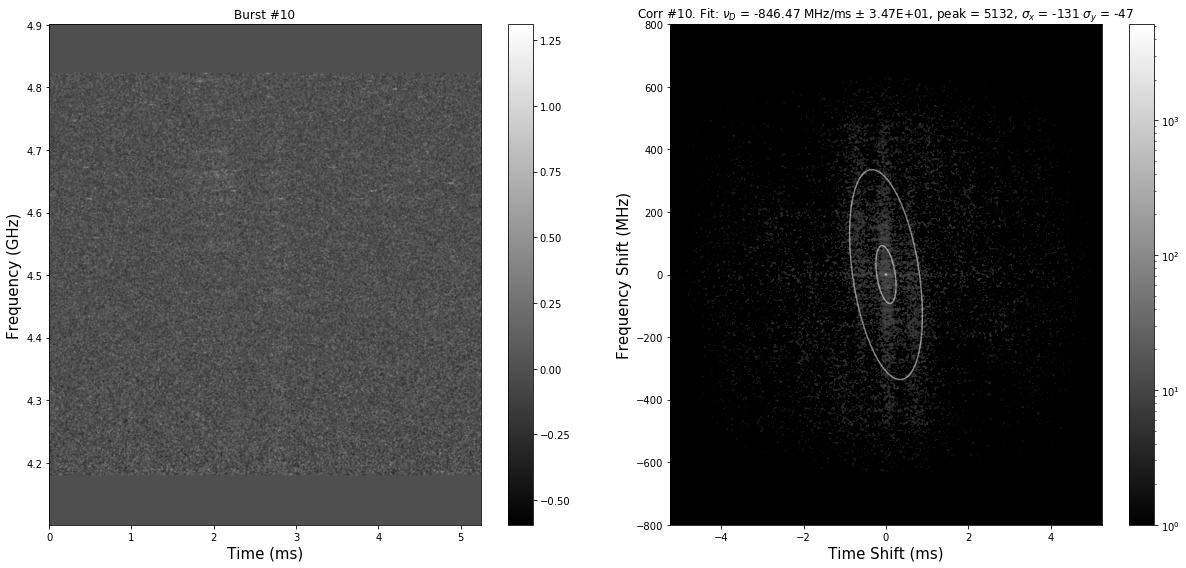

In [8]:
    ### 3.5 Compute drift and error
    theta = popt[-1] if abs(popt[3]) > abs(popt[4]) else popt[-1] - np.pi/2
    print('solver angle:', popt[-1], 'pos angle:', theta)
    slope = np.tan(theta)
    drift = 1.5625/0.01024 * slope # MHz/ms
    drift_error = (1.5625/0.01024) * (perr[-1] * (1/np.cos(theta))**2)
    print('drift:', drift)
    print('drift error:', drift_error)
    
    #### 4. Plot
    cmap = plt.get_cmap('gray')
    cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!

    plt.figure(figsize=(17,8))
    plt.subplot(121)
    plt.title("Burst #{}".format(burst))
    burstextents = [0, 
           10.24e-6 * burstwindow.shape[-1] * 1e3, 
           4100.78125 * 1e-3, 
           (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    plt.colorbar()

    plt.subplot(122)
    plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, np.max(corr), popt[3], popt[4]))
    # plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower") # linear scale
    # plt.clim(0, np.max(corr)/2)
    corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
           10.24e-6 * (corr.shape[1]/2) * 1e3 , 
           (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
           ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    plt.colorbar()
    
    plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

    plt.tight_layout()
    plt.savefig('{}/burst_{}_figure.png'.format(outfolder, burst))
    print('saved {}/burst_{}_figure.png'.format(outfolder, burst))

In [ ]:
cmap = plt.get_cmap('PiYG')
cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!

plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title("Burst #{}".format(burst))
burstextents = [0, 
       10.24e-6 * burstwindow.shape[-1] * 1e3, 
       4100.78125 * 1e-3, 
       (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
plt.xlabel("Time (ms)", size=15)
plt.ylabel("Frequency (GHz)", size=15)
plt.clim(0, 0.3)
print(np.median(burstwindow))
plt.colorbar()

plt.subplot(122)
plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, np.max(corr), popt[3], popt[4]))
# plt.imshow(corr, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower") # linear scale
# plt.clim(0, np.max(corr)/2)
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
       10.24e-6 * (corr.shape[1]/2) * 1e3 , 
       (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
       ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1), extent=corrextents)
plt.xlabel("Time Shift (ms)", size=15)
plt.ylabel("Frequency Shift (MHz)", size=15)
plt.colorbar()

plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,10))
cmap = plt.get_cmap('gray')
cmap.set_bad(color = 'k', alpha = 1.)
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1))
print(np.max(corr), np.min(corr))
# linear cmap
# plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")
# plt.clim(0, np.max(corr)/2)

plt.colorbar()


In [ ]:
cmap = "gray"
x = range(0, 1023); y = range(0, 1023)
x, y = np.meshgrid(x, y)
# amplitude, xo, yo, sigma_x, sigma_y, theta
testmap = twoD_Gaussian((x, y), *[1.8e+03, 5.11e+02, 5.11e+02, 1.74e+02, 4.7e+01, 1.425]).reshape(1023, 1023)
popt = [1.8e+03, 5.11e+02, 5.11e+02, 1.74e+02, 4.7e+01, 1.425]

plt.figure(figsize=(10,8))
plt.title("Correlation #{}. Fit: $\\theta$ = {:.2f} rad, peak = {:.0f}, $\sigma_x$ = {} $\sigma_y$ = {}".format(burst, popt[-1], 1000, 1, 1))
print(burstwindow.shape)
burstextents = [0, 
           10.24e-6 * burstwindow.shape[-1] * 1e3, 
           4100.78125 * 1e-3, 
           (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]

plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)
plt.xlabel("Time (ms)", size=20)
plt.ylabel("Frequency (GHz)", size=20)
plt.colorbar()


In [ ]:
x = range(0, 1023); y = range(0, 1023)
x, y = np.meshgrid(x, y)
popt = [1,2,3,4,5,6]; burst = 1
fitmap2 = twoD_Gaussian((x, y), *popt).reshape(1023, 1023)
drift = 1; perr = 1
cmap = "gray"
plt.figure(figsize=(10,10))
plt.title("Corr #{}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2f}, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(1,1,1,1,1,1))
# plt.title("TESTCorr #{}. Fit: $\\theta$ = {:.2f}rad, peak = {:.0f}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, popt[-1], np.max(corr), popt[3], popt[4]))
# corrextents = [-10.24e-6 * corr.shape[1] * 1e3 / 2, 
#            10.24e-6 * corr.shape[1] * 1e3 / 2, 
#            (4100.78125 -  (4100.78125 + 1.5625*corr.shape[0]/2) ) * 1e-3, 
#            (4100.78125 +  (4100.78125 + 1.5625*corr.shape[0]/2) ) * 1e-3]
plt.imshow(fitmap2, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", norm=mcolors.LogNorm(vmin=1))#, extent=corrextents)
plt.colorbar()
# plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

In [ ]:
corrextents = [-10.24e-6 * (corr.shape[1]/2) * 1e3, 
           10.24e-6 * (corr.shape[1]/2) * 1e3 , 
           (4100.78125 -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2, 
           ((4100.78125 + 1.5625*burstwindow.shape[-2]) -  (2*4100.78125 + 1.5625*burstwindow.shape[0])/2 )*2]
corrextents